# Importing the data

First, we will start by importing a `pandas.DataFrame` of the scraped data. For the purpose of this example, the data has already been scraped and stored in `donald_trump.csv`. 

instascrape has been designed in such a way to be highly compatible with `pandas` and thus tabular data is standard usage for manipulating scraped data.  

In [1]:
import ast 

import pandas as pd 

df = pd.read_csv(
    "donald_trump.csv", 
    converters={
        "hashtags":ast.literal_eval, 
        "tagged_users":ast.literal_eval,
    }
)
df["upload_date"] = pd.to_datetime(df["upload_date"])

# Preprocessing our data 
 
Now that we have our data in a `pandas.DataFrame`, let's prepare it to be fitted with a `scikit.linear_model.LinearRegression`. We will start by using `sklearn.preprocessing.StandardScaler` to scale our data into an appropriate range. 

In [2]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()      
sc_y = StandardScaler()

# Convert a 1D numpy array into a 2D column-like array. 
def two_dimensionalize(arr): return arr.reshape((len(arr), 1))

# StandardScaler.fit_transform expects a 2D-array. 
x_dt = df['timestamp'].to_numpy()
x_dt = two_dimensionalize(x_dt)
y_dt = df['likes'].to_numpy()
y_dt = two_dimensionalize(y_dt)

# Feature scaling to get data on same scale.
x_transform = sc_x.fit_transform(x_dt)
y_transform = sc_y.fit_transform(y_dt)

Now that our data is scaled appropriately, we are going to create a new feature matrix with data prepared for a polynomial regression. To do so, we will transform our data with `sklearn.preprocessing.PolynomialFeatures`

In [3]:
from sklearn.preprocessing import PolynomialFeatures

#Further scaling for IV.
polyreg = PolynomialFeatures(degree=6)
x_poly = polyreg.fit_transform(x_transform)

# Fitting the polynomial regressor

Now that our data has been preprocessed and we have an appropriate feature matrix for fitting a polynomial regression, we will fit our data and get a set of dependant variables predicted by the regressor. 

In this case, we will use these values to plot a curve fit to show underlying trends in a scatter plot. 

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

#Create and fit polynomial regression. 
regressor = LinearRegression()
regressor.fit(x_poly, y_transform)

#Calculate predictions from the model for every independant variable data point.  
y_predict = np.array([regressor.predict([val]) for val in x_poly])
y_predict = two_dimensionalize(y_predict)
y_final = sc_y.inverse_transform(y_predict)
y_final = y_final.flatten()

# Visualizing our data

Now with our data and polynomial regression, we can create a scatter plot to visualize user engagement over the last few months.

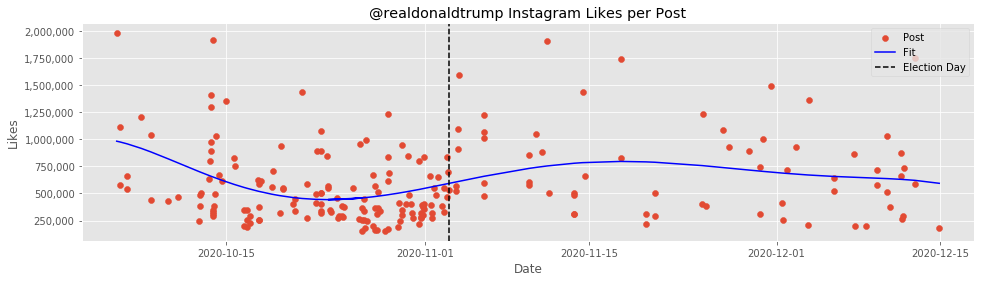

In [14]:
import datetime

import matplotlib.pyplot as plt
import matplotlib

# Create plot and style. 
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,4))

# Draw scatter plot.
upload_date = df["upload_date"].to_numpy()
likes = df["likes"].to_numpy()
ax.scatter(upload_date, likes, label="Post")

# Draw polynomial regression.
ax.plot(upload_date, y_final, label='Fit', color="blue")

# Draw Election Day vertical line. 
election_date = datetime.date(2020, 11,3)
ax.axvline(election_date, linestyle='--', label="Election Day", color="black")

# Set plot x-bounds. 
left_xlim=df["upload_date"].min()-datetime.timedelta(days=3)
right_xlim=df["upload_date"].max()+datetime.timedelta(days=3)
ax.set_xlim(left=left_xlim, right=right_xlim)

# Draw labels on plot. 
ax.set_title("@realdonaldtrump Instagram Likes per Post")
ax.set_xlabel("Date")
ax.set_ylabel("Likes")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Format and draw plot legend.
handles,labels = ax.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
ax.legend(handles,labels, loc=1)

# Analyzing tagged locations 

Now that we have our visualization, there are a couple other interesting data points that we can analyze. 

First, let's take a look at all the locations that Donald Trump has tagged in his photos. Since we don't care about posts where he didn't tag a location, we'll just drop those so we can focus on posts where he did tag a location. 

In [6]:
locations_df = df[df["location"].notna()]
locations_count = locations_df["location"].explode().value_counts()
locations_count

Information icon.                               113
The White House                                  22
Pennsylvania                                      4
Michigan                                          4
Johnstown, Pennsylvania                           3
Greenville, North Carolina                        1
Lititz, Pennsylvania                              1
Des Moines, Iowa                                  1
Texas                                             1
Erie, Pennsylvania                                1
Reading, Pennsylvania                             1
Arizona                                           1
The Villages, Florida                             1
North Carolina                                    1
Las Vegas, Nevada                                 1
Lumberton, North Carolina                         1
Janesville, Wisconsin                             1
Gastonia, North Carolina                          1
Walter Reed National Military Medical Center      1
Tucson, Ariz

Text(0.5, 1.0, "Donald Trump's Tagged Locations")

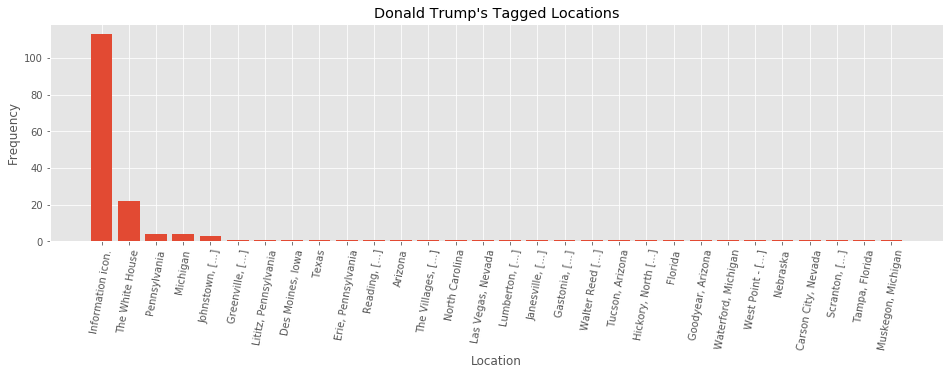

In [7]:
from textwrap import shorten

fig, ax = plt.subplots(figsize=(16,4))

locations = locations_count.index.to_list()
formatted_locations = [shorten(loc, width=20) for loc in locations]
frequency = locations_count.to_list()
ax.bar(formatted_locations, frequency)

ax.set_xlabel("Location")
plt.xticks(rotation=80)
ax.set_ylabel("Frequency")
ax.set_title("Donald Trump's Tagged Locations")

In [8]:
percent_location = len(locations_df)/len(df)
print(f"Donald Trump tagged a location in {percent_location:.2%} of his recent posts.")

Donald Trump tagged a location in 82.21% of his recent posts.


# Analyzing other tagged accounts

Now let's analyze how many times Donald Trump tagged someone else in one of his posts.

In [9]:
tagged_df = df[df["tagged_users"].str.len() != 0]
tagged_df["tagged_users"]

92    [ivankatrump]
Name: tagged_users, dtype: object

In [10]:
percent_tagged = len(tagged_df)/len(df)
print(f"Donald Trump tagged another account in {percent_tagged:.2%} of his recent posts.")

Donald Trump tagged another account in 0.48% of his recent posts.


If you're interested in seeing the post, let's get the shortcode for this single post so you can navigate to the URL yourself and confirm Ivanka Trump is in it. 

In [11]:
shortcode = tagged_df.iloc[0]['shortcode']
print(f"https://www.instagram.com/p/{shortcode}/")

https://www.instagram.com/p/CG-ahVPMUyw/


# Analyzing Trump's hashtags 

As a final exercise, let's check out what hashtags Donald Trump uses in his posts.


In [12]:
hashtags_df = df[df["hashtags"].str.len() != 0]
hashtags_count = hashtags_df["hashtags"].explode().value_counts()
hashtags_count


Repost              28
MAGA                19
VOTE                 9
KeepAmericaGreat     2
Georgia              1
donaldtrump          1
HappyHalloween       1
president            1
thehenningsens       1
WeDeserveToKnow      1
northcarolina        1
Michigan             1
whyIfarm             1
charlotte            1
Name: hashtags, dtype: int64

Text(0.5, 1.0, "Donald Trump's Hashtag Usage")

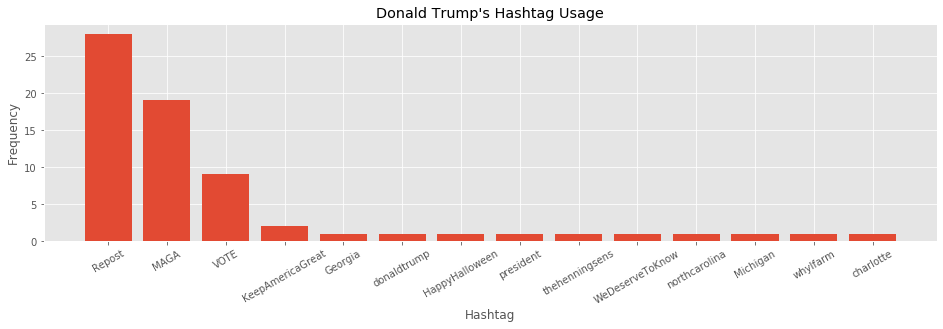

In [13]:
fig, ax = plt.subplots(figsize=(16,4))

hashtags = hashtags_count.index.to_list()
frequency = hashtags_count.to_list()
ax.bar(hashtags, frequency)

ax.set_xlabel("Hashtag")
plt.xticks(rotation=30)
ax.set_ylabel("Frequency")
ax.set_title("Donald Trump's Hashtag Usage")